In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Transform: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
# Load MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.88MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


In [5]:
# Add noise to images
def add_noise(inputs, noise_factor=0.5):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    return torch.clamp(noisy, 0., 1.)


In [6]:
# Define Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),   # (1,28,28) -> (32,14,14)
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (32,14,14) -> (64,7,7)
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64,7,7) -> (32,14,14)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # (32,14,14) -> (1,28,28)
            nn.Sigmoid()  # Output in range [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Initialize model, loss function and optimizer
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Print model summary
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
   ConvTranspose2d-5           [-1, 32, 14, 14]          18,464
              ReLU-6           [-1, 32, 14, 14]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]             289
           Sigmoid-8            [-1, 1, 28, 28]               0
Total params: 37,569
Trainable params: 37,569
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.14
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [9]:
# Train the autoencoder
def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)

            # Forward pass
            outputs = model(noisy_images)
            loss = criterion(outputs, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(loader):.4f}")


In [10]:
# Evaluate and visualize
def visualize_denoising(model, loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            break

    images = images.cpu().numpy()
    noisy_images = noisy_images.cpu().numpy()
    outputs = outputs.cpu().numpy()

    print("Name:CHANDRU.P")
    print("Register Number: 212223110007")

    plt.figure(figsize=(18, 6))
    for i in range(num_images):
        # Original
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title("Original")
        plt.axis("off")

        # Noisy
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        ax.set_title("Noisy")
        plt.axis("off")

        # Denoised
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        ax.set_title("Denoised")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Epoch [1/5], Loss: 0.1172
Epoch [2/5], Loss: 0.1120
Epoch [3/5], Loss: 0.1120
Epoch [4/5], Loss: 0.1120
Epoch [5/5], Loss: 0.1120
Name:CHANDRU.P
Register Number: 212223110007


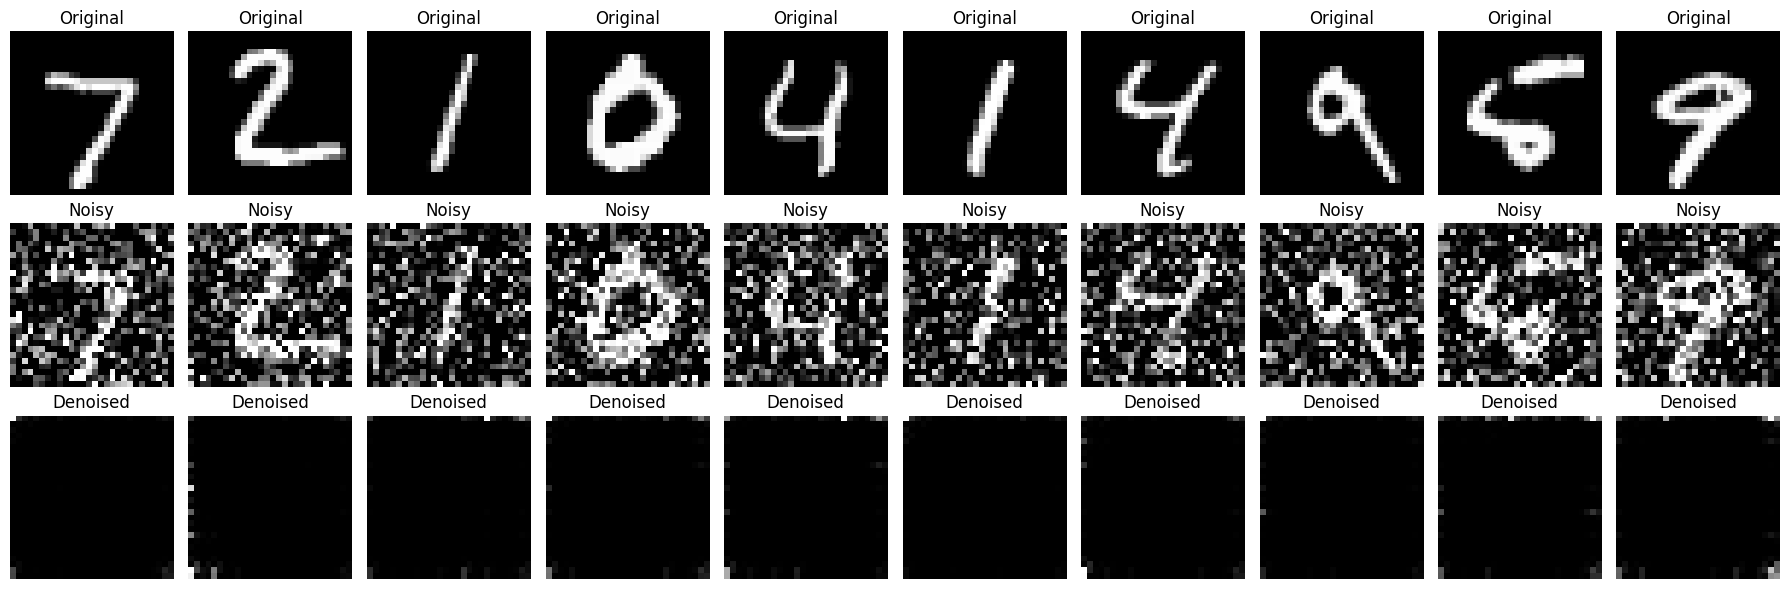

In [11]:
# Run training and visualization
train(model, train_loader, criterion, optimizer, epochs=5)
visualize_denoising(model, test_loader)